In [1]:
import cv2
import numpy as np
from importnb import Notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.fft as fft
import numpy.matlib
from skimage.transform import rotate
import sys
from tqdm import tqdm_notebook as tqdm

In [2]:
with Notebook(): 
        import utils
        import pinkNoise
        import reblur

## patch recurence

In [28]:
img = utils.loadImage('./resources/building_small.jpg', 'gray')
x, K = utils.nonUniformBlur(img)

image ./resources/building_small.jpg loaded


In [30]:
def downscale(x, alpha, show=False):
    '''
     @input: blurred img x
     @input: estimated kernel k

     @return: deblurred image
    '''


    downscaled_image = cv2.resize(x,None, fx=1/alpha,fy=1/alpha,interpolation=cv2.INTER_LANCZOS4)
    
    if show:
        plt.imshow(downscaled_image, cmap='gray')
        plt.figure()
        plt.imshow(x, cmap='gray')
        plt.show()
        downscaled_image.shape, x.shape
    
    return downscaled_image

In [31]:
def getPriorPatch(patch, img, h):
    k = patch.shape[0]
    n,m = img.shape
    
    num = np.zeros((k,k))
    denom = 0
    
    cimg = utils.im2col(img, [k,k])
    cpatch = patch.ravel()[:,None]
    
    prob = np.exp(-np.mean((cpatch - cimg)**2, axis=0)/(2*(h**2)))
    denom = np.sum(prob)
    num = cimg @ prob[:,None]
    num = num.reshape((k,k))
    
#     for i in range(k//2+1, n-k//2):
#         for j in range(k//2+1, m-k//2):
#             splice = img[i-k//2:i+k//2+1, j-k//2:j+k//2+1]
#             err = np.mean((patch - splice)**2)
#             exp = -err/(2*(h**2))
            
#             p = np.exp(exp)
#             num += p * splice
#             denom += p
            
    return num/(denom*k*k)

def getPrior(img, patch_size, alpha, h, stride):
    M = patch_size
    x_alpha = downscale(img, alpha)
    
    n,m = img.shape
    
    z = np.zeros(img.shape)
    for i in tqdm(range(M//2, n-M//2)):
        for j in range(M//2, m-M//2):
            patch = img[i-M//2:i+M//2+1, j-M//2:j+M//2+1]    
            z[i-M//2:i+M//2+1, j-M//2:j+M//2+1] += getPriorPatch(patch, x_alpha, h)
    return z

In [35]:
z = getPrior(x, 21, 4/3, 10, 1)

/envs/bluring/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

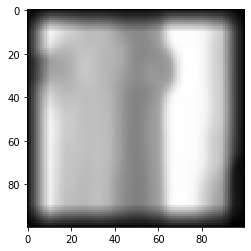

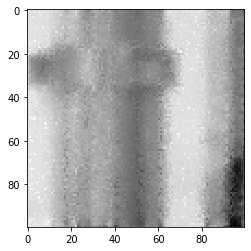

In [27]:
plt.imshow(z, cmap='gray')
plt.show()
plt.imshow(x, cmap='gray')